In [27]:
import json
from matplotlib import pyplot as plt
import seaborn as sns

In [28]:
GATHER_RUN = 'appropriated-pichu'
PR_RUN = 'balding-seadra'

In [29]:
import os
def get_results(runs):
    runs_dir = "logs/eval"
    contents = os.listdir(runs_dir)
    run_paths = []
    for run in runs:
        run_paths.extend([run_path for run_path in contents if run in run_path])
    print(run_paths)
    data = []
    for run_path in run_paths:
        with open(os.path.join(runs_dir, run_path), "r") as f:

            data.extend(json.load(f))

def save_show(fname, run_dir):
    if fname is not None:
        fname = fname.replace(' ', '_').replace('\n', '_')
        plt.savefig(f"{run_dir}/{fname}.pdf", format="pdf")
    plt.show()



In [30]:
repos_dir = 'resources/dataset/tags'
repo_paths = [os.path.join(repos_dir, r) for r in [
    "1-5k.json",
    "5-10k.json",
    "10-20k.json",
    "20k+.json",
]]
repos = []
for path in repo_paths:
    batch = json.load(open(path, 'r'))
    for repo in batch:
        repo['location'] = path
    repos.extend(batch)
repos = {r['url'].split('/')[-1][:-4]: r for r in repos}

In [31]:
run = GATHER_RUN
run_dir = run_dir = f"figs/{run}"
res = json.load(open(f'logs/eval/{run}_gpt-4o-mini.json', 'r'))
os.makedirs(run_dir, exist_ok=True)

In [32]:

from typing import List, Optional, Union

import numpy as np


def scatter(
    x_data: List[Union[int, float]],
    y_data: List[Union[int, float]],
    x_label: str = "x",
    y_label: str = "y",
    title: str = "title",
    lobf: bool = True,
    cmap="Dark2",
    cindex=4,
):
    colors = plt.colormaps[cmap]
    if lobf:
        x = np.array(x_data)
        y = np.array(y_data)
        m, b = np.polyfit(x, y, 1)
        sns.regplot(x=x, y=y, color=colors(cindex), ci=95)
        plt.plot(
            x,
            m * x + b,
            label=f"coefficient = {round(m, 3)}",
            linewidth=1,
            color=colors(cindex),
        )
        plt.legend()
    else:
        plt.scatter(x_data, y_data)

    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.ylim(-0.05, 1.05)
    save_show(title, run_dir)


def multi_scatter(
    x_data: List[List[Union[int, float]]],
    y_data: List[List[Union[int, float]]],
    group_labels: List[str],
    x_label: str = "x",
    y_label: str = "y",
    title: str = "title",
    lobf: bool = False,
    loc: Optional[str] = None,
    cmap="Dark2",
    conf_interval=95,
):
    colors = plt.colormaps[cmap]
    for i, (xd, yd, label) in enumerate(zip(x_data, y_data, group_labels)):
        if lobf:
            x = np.array(xd)
            y = np.array(yd)
            m, b = np.polyfit(x, y, 1)
            sns.regplot(x=x, y=y, color=colors(i), ci=conf_interval)

            plt.plot(x, m * x + b, color=colors(i), label=label + f" ({round(m, 3)})")
        else:
            plt.scatter(xd, yd, color=colors(i))
    # plt.scatter(x_data, y_data)

    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    if loc is not None:
        plt.legend(loc=loc)
    else:
        plt.legend()
    plt.ylim(-0.05, 1.05)

    save_show(title, run_dir)


In [33]:
from matplotlib.ticker import MaxNLocator

def bar(
    values: List[Union[float, int]],
    categories: List[str],
    x_label: str = "x",
    y_label: str = "y",
    title: str = "title",
    avg: Optional[float] = None,
    rotation: Optional[int] = 90,
    fsize: Optional[int] = 6
):
    categories, values = zip(*sorted(zip(categories, values), key=lambda x: (
        (x[1] if x[0] != 'other' else -1)
        if isinstance(x[0], str) else x[0]
    )))

    plt.bar([str(c) for c in categories], values)
    if avg is not None:
        plt.axhline(avg, color="red", label=f"average installation rate = {round(avg, 3)}")
        plt.legend()
    if len(categories) > 5:
        plt.xlabel(x_label, labelpad=-10, fontsize=14)
        plt.xticks(rotation=rotation, fontsize=fsize, ha='right')
    else:
        plt.xlabel(x_label, fontsize=12)
        plt.xticks(fontsize=fsize)
    if max(values) > 1:
        plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.ylabel(y_label, fontsize=12)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    save_show(title, run_dir)

In [34]:
def gen_failed_run():
    return {'retrieved': [],
  'relevant': ['docs/en/docs/contributing.md',
   'docs/en/docs/tutorial/testing.md'],
  'recall': 0,
  'summary': None,
  'gather_tokens': None,
  'build_status': 'failure',}

def group_by_tags(results, tags: List[List[str]]):
    ret = [[r for r in results.values() if any(t in r['tags'] for t in tag)] for tag in tags]
    ret.append([r for r in results.values() if not any([any(t in r['tags'] for t in tag) for tag in tags])])
    return ret

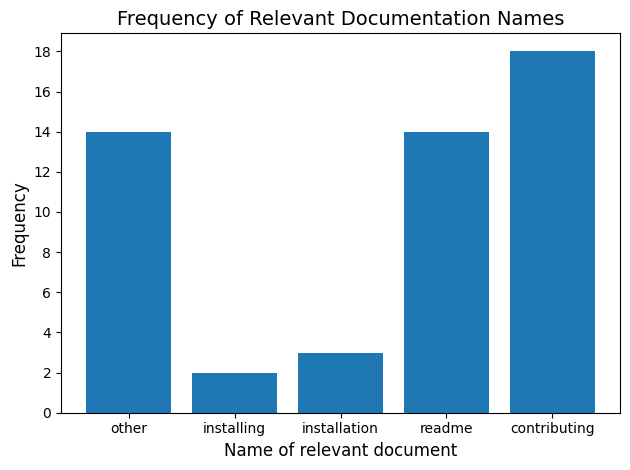

In [35]:
from collections import Counter
doc_files = [repo['relevant_docs'] for repo in repos.values()]
doc_files_clean = Counter([doc.split('/')[-1].split('.')[0].lower().replace('-', '_') for docs in doc_files for doc in docs])
vals = {key: val for key, val in doc_files_clean.items() if val > 1}
vals['other'] = sum([v for v in doc_files_clean.values() if v <= 1])
bar(
    vals.values(),
    vals.keys(),
    x_label="Name of relevant document",
    y_label="Frequency",
    title="Frequency of Relevant Documentation Names",
    fsize=10
)

# RESULTS FOR GATHER STEP

In [36]:
run = GATHER_RUN
run_dir = run_dir = f"figs/{run}"
gather_res = json.load(open(f'logs/eval/{run}_gpt-4o-mini.json', 'r'))
os.makedirs(run_dir, exist_ok=True)

In [37]:
# COLLECT RESULTS
flat_gather_res = [(key, val) for round in gather_res for key, val in round.items() if 'build_status' in val]
res_repos = set([r[0] for r in flat_gather_res])

valid_repos = set(res_repos).intersection(set(repos.keys()))
res_by_repos = {repo: [r[1] for r in flat_gather_res if r[0] == repo] for repo in valid_repos}
max_len = max([len(rr) for rr in res_by_repos.values()])
gather_results = {
    repo: {
        'recall': sum([r['recall'] for r in rr]) / len(rr),
        'precision': (sum([r['recall'] * len(r['relevant']) / len(r['retrieved']) for r in rr if len(r['retrieved']) > 0]) / len(rr)),
        'install_rate_max': (len([r for r in rr if r['build_status'] == 'success'])) / max_len,
        'install_rate': (len([r for r in rr if r['build_status'] == 'success'])) / len(rr),
        'info': repos[repo]['info'],
        'visibility': repos[repo]['visibility'],
        'tags': repos[repo]['tags'],
        'docs': repos[repo]['relevant_docs'],
        'location': repos[repo]['location'],
        'duration': sum([r['duration'] for r in rr]) / len(rr)
    }
    for repo, rr in res_by_repos.items()
}
gather_info_results = {key: val for key, val in gather_results.items() if val['info'] >= 0}
gather_installable_results = {key: val for key, val in gather_info_results.items() if val['install_rate'] > 0} 


In [45]:
success_res = [r[1] for r in flat_gather_res if r[1]['build_status'] == 'success']
fail_res = [r[1] for r in flat_gather_res if r[1]['build_status'] != 'success']
print(f"max run duration: {max([r[1]['duration'] for r in flat_gather_res])}")
print(f"average run duration: {sum([r[1]['duration'] for r in flat_gather_res]) / len(flat_gather_res)}")


max run duration: 4787.876837730408
average run duration: 501.82985031724576


In [39]:
extra_groups = [['extra', 'pip-extra', 'requirements-extra', 'poetry-extra', 'pytest-extra', 'bash-extra']]
extra_grouped_repos = group_by_tags(gather_results, extra_groups)

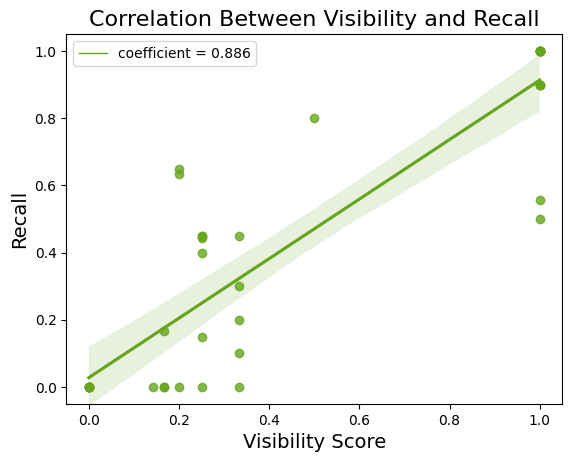

In [40]:
run = GATHER_RUN
run_dir = run_dir = f"figs/{run}"
scatter(
    [r['visibility'] for r in gather_results.values()],
    [r['recall'] for r in gather_results.values()],
    "Visibility Score",
    "Recall",
    "Correlation Between Visibility and Recall",
    # cmap="Dark2",
    # cindex=4
)

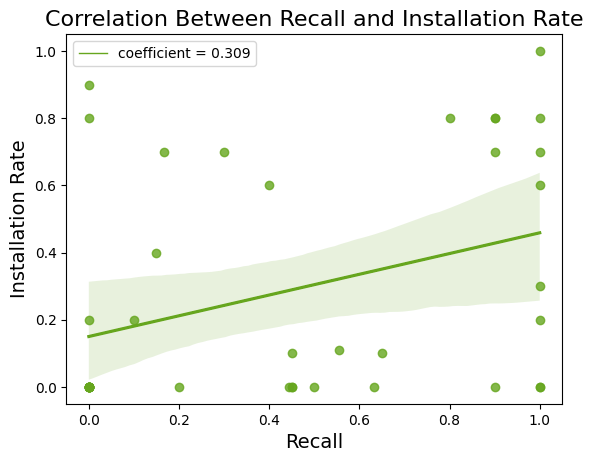

In [41]:
run = GATHER_RUN
run_dir = run_dir = f"figs/{run}"
scatter(
    [r['recall'] for r in gather_results.values()],
    [r['install_rate'] for r in gather_results.values()],
    'Recall',
    'Installation Rate',
    "Correlation Between Recall and Installation Rate"
)

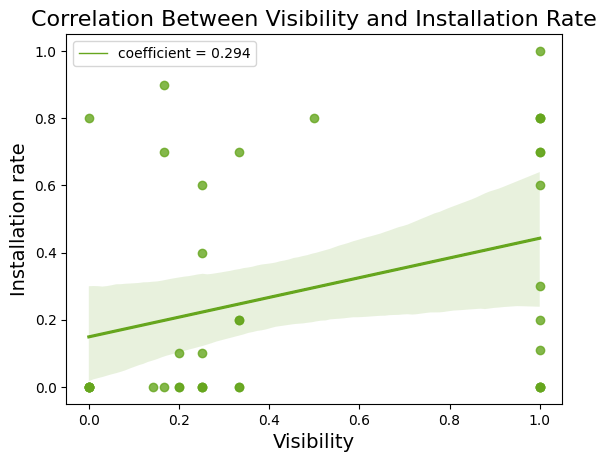

In [42]:
run = GATHER_RUN
run_dir = run_dir = f"figs/{run}"
scatter(
    [r['visibility'] for r in gather_results.values()],
    [r['install_rate'] for r in gather_results.values()],
    'Visibility',
    'Installation rate',
    "Correlation Between Visibility and Installation Rate"
)

115


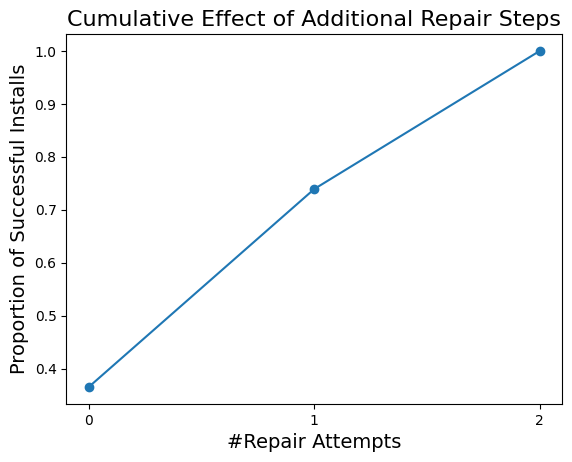

In [52]:
from typing import Counter
run = GATHER_RUN
run_dir = run_dir = f"figs/{run}"
num_success = len(success_res)
print(num_success)
tries_cnt = Counter([r['n_tries'] for r in success_res])
cumulative_success = {0: tries_cnt[0]}
for n in range(len(tries_cnt.keys())):
    if n == 0:
        continue
    cumulative_success[n] = cumulative_success[n - 1] + tries_cnt[n]
plt.plot(
    list(cumulative_success.keys()),
    [v / num_success for v in cumulative_success.values()],
    marker='o'
)
xlabel = '#Repair Attempts'
ylabel = 'Proportion of Successful Installs'
title = 'Cumulative Effect of Additional Repair Steps'
plt.xlabel(xlabel, fontsize=14)
plt.ylabel(ylabel, fontsize=14)
plt.title(title, fontsize=16)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
save_show(title, run_dir)

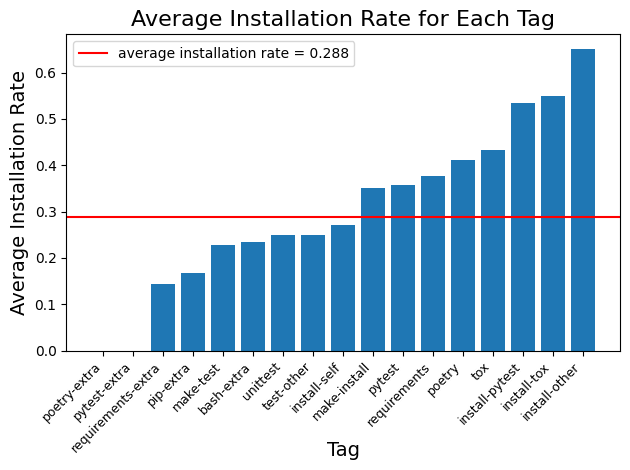

In [28]:
run = GATHER_RUN
run_dir = run_dir = f"figs/{run}"
gather_avg_install_rate = round(sum([repo['install_rate'] for repo in gather_results.values()]) / len(gather_results), 3)
tags = list(set([tag for repo in gather_results.values() for tag in repo['tags']]))

tag_groups = group_by_tags(gather_info_results, [[t] for t in tags])
tag_brs = [sum([repo['install_rate'] for repo in group]) / len(group) for group in tag_groups[:-1]]

bar(
    tag_brs,
    tags,
    'Tag',
    'Average Installation Rate',
    'Average Installation Rate for Each Tag',
    avg=gather_avg_install_rate,
    rotation=45,
    fsize=9
)

# RESULTS FOR PERFECT RECALL

In [17]:
run = PR_RUN
pr_res = json.load(open(f'logs/eval/{run}_gpt-4o-mini.json', 'r'))
run_dir = run_dir = f"figs/{run}"
os.makedirs(run_dir, exist_ok=True)

In [18]:
# COLLECT RESULTS

pr_flat_res = [(key, val) for round in pr_res for key, val in round.items() if 'build_status' in val]
res_repos = set([r[0] for r in pr_flat_res])

valid_repos = set(res_repos).intersection(set(repos.keys()))
res_by_repos = {repo: [r[1] for r in pr_flat_res if r[0] == repo] for repo in valid_repos}
max_len = max([len(rr) for rr in res_by_repos.values()])
pr_results = {
    repo: {
        'recall': sum([r['recall'] for r in rr]) / len(rr),
        'precision': (sum([r['recall'] * len(r['relevant']) / len(r['retrieved']) for r in rr if len(r['retrieved']) > 0]) / len(rr)),
        'install_rate': (len([r for r in rr if r['build_status'] == 'success'])) / len(rr),
        'install_rate_max': (len([r for r in rr if r['build_status'] == 'success'])) / max_len,
        'info': repos[repo]['info'],
        'visibility': repos[repo]['visibility'],
        'tags': repos[repo]['tags'],
        'docs': repos[repo]['relevant_docs'],
        'location': repos[repo]['location'] 
    }
    for repo, rr in res_by_repos.items()
}
pr_info_results = {key: val for key, val in pr_results.items() if val['info'] >= 0}
pr_installable_results = {key: val for key, val in pr_info_results.items() if val['install_rate'] > 0} 


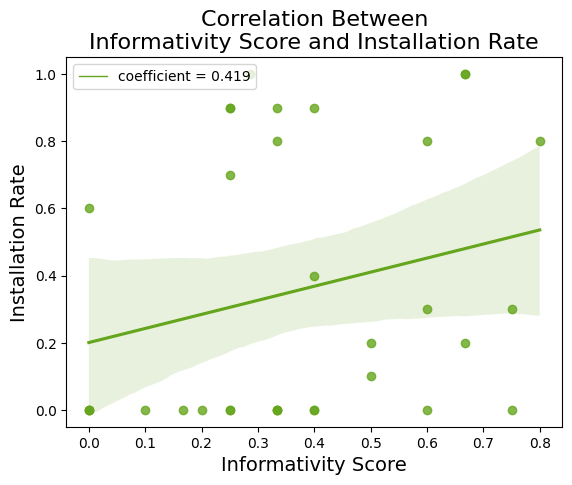

In [19]:
run = PR_RUN
run_dir = run_dir = f"figs/{run}"

scatter(
    [r['info'] for r in pr_info_results.values()],
    [r['install_rate'] for r in pr_info_results.values()],
    'Informativity Score',
    'Installation Rate',
    "Correlation Between\nInformativity Score and Installation Rate"
)

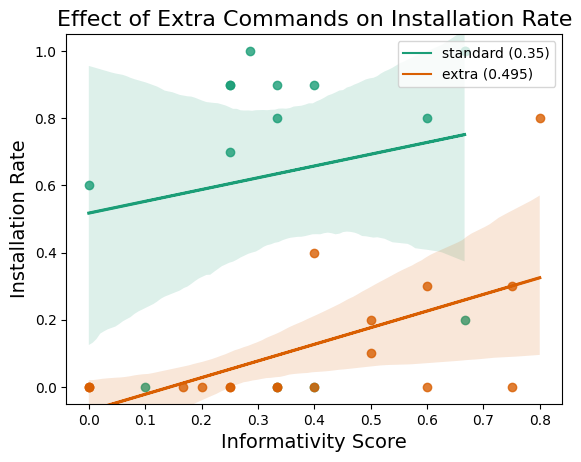

In [20]:
run = PR_RUN
run_dir = run_dir = f"figs/{run}"
extra_groups = [['extra', 'pip-extra', 'requirements-extra', 'poetry-extra', 'pytest-extra', 'bash-extra']]
extra_grouped_repos = group_by_tags(pr_info_results, extra_groups)
multi_scatter(
    reversed([[r['info'] for r in res] for res in extra_grouped_repos]),
    reversed([[r['install_rate'] for r in res] for res in extra_grouped_repos]),
    reversed([res[0] for res in extra_groups] + ['standard']),
    "Informativity Score",
    "Installation Rate",
    "Effect of Extra Commands on Installation Rate",
    lobf=True

)

In [21]:
tags = list(set([tag for repo in pr_results.values() for tag in repo['tags']]))
pr_avg_install_rate = round(sum([repo['install_rate'] for repo in pr_results.values()]) / len(pr_results), 3)

In [26]:
from matplotlib.ticker import NullLocator


def multi_bar(
    values: List[List[Union[float, int]]],
    categories: List[str],
    labels: List[str],
    x_label: str = "x",
    y_label: str = "y",
    title: str = "title",
    avgs: Optional[List[float]] = None,
    cmap="Dark2",
):
    # zipper = list(zip(*sorted(zip(categories, *values), key=lambda x: x[1] if x[1] >= 0 else 100 if x[1] < 0 else x[2])))
    zipper = list(zip(*sorted(zip(categories, *values), key=lambda x: x[1] if x[1] > 0 else 100 if x[1] == -1 else x[2])))
    categories = zipper[0]
    values = zipper[1:]
    colors = plt.colormaps[cmap]
    
    # remove minor ticks
    fig, ax = plt.subplots()
    ax.xaxis.set_minor_locator(NullLocator())

    for i, (vals, lbl) in enumerate(zip(values, labels)):
        plt.bar(categories, vals, color=colors(i), alpha=0.8 if i == 0 else 0.6)
    if avgs is not None:
        for i, (avg, label) in enumerate(zip(avgs, labels)):
            plt.axhline(avg, color=colors(i), label=f"{label}\n(avg={round(avg, 3)})")
            plt.legend()
    plt.xlabel(x_label, labelpad=-10, fontsize=14)
    plt.xticks(rotation=90, fontsize=10)
    plt.ylabel(y_label, fontsize=14)
    plt.title(title, fontsize=16)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    save_show(title, run_dir)

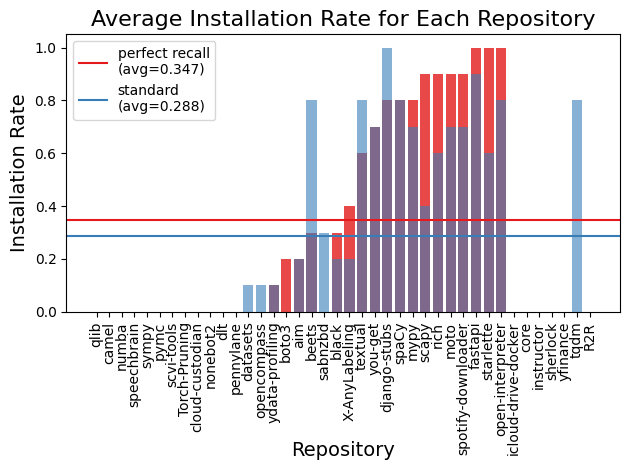

In [27]:
run = PR_RUN
run_dir = run_dir = f"figs/{run}"
multi_bar(
    [
        [pr_info_results[repo]['install_rate_max'] if repo in pr_info_results else -1 for repo in gather_results.keys()],
        [r['install_rate_max'] for r in gather_results.values()],
    ],
    gather_results.keys(),
    ["perfect recall", "standard"],
    'Repository',
    'Installation Rate',
    'Average Installation Rate for Each Repository',
    avgs=[pr_avg_install_rate, gather_avg_install_rate],
    cmap="Set1"
)